<a href="https://colab.research.google.com/github/arumajirou/-daily-test/blob/main/run_DiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **トランスフォーマーによるスケーラブルな拡散モデル(DiT)**
このノートブックでは、事前に学習した**DiTモデル**からサンプルを抽出します。DiTはImageNetで学習した**クラス条件付き潜在拡散モデル**で、**DDPM**のバックボーンとして**U-Nets**の代わりにトランスフォーマーを使用しています。DiTはImageNetのベンチマークにおいて、全ての先行拡散モデルを凌駕する性能を発揮します。

[Project Page](https://www.wpeebles.com/DiT) | [HuggingFace Space](https://huggingface.co/spaces/wpeebles/DiT) | [Paper](http://arxiv.org/abs/2212.09748) | [GitHub](github.com/facebookresearch/DiT)

- 我々は、トランスフォーマー構造に基づく新しいクラス(設計図)の拡散モデル(計算式/計算法)を探求している。

- 我々は、一般的に使用されているU-Netのバックボーン(高速・大容量のネットワーク回線のこと)を、潜在的なパッチ(ソフトに変更を加えるために用意された、後付けのプログラムのこと)上で動作するトランスフォーマーに置き換え、画像の潜在的な拡散モデル(計算式/計算法)を学習する。

- 我々は、Gflops(コンピュータの処理性能を表す単位のうち、浮動小数点演算を1秒間に10億回行うことを示す単位)で測定されるフォワードパス(順伝搬)の複雑さというレンズを通して、我々の拡散トランスフォーマー（DiT）のスケーラビリティ(機器やソフトウェア、システムなどの拡張性、拡張可能性のこと)を分析する。

- その結果、変換器の深さや幅、あるいは入力トークン(文を作る最小の構成要素)の数によってGflops(コンピュータの処理性能を表す単位のうち、浮動小数点演算を1秒間に10億回行うことを示す単位)が高くなるDiTは、一貫してFID(Frechet Inception Distance =フレシェ開始距離(本物と生成された画像それぞれの埋め込み表現を計算し、それらの平均と共分散を比較し、その距離が近い、つまり値が小さいほど良いスコア) )が低くなることがわかった。

- さらに、DiT-XL/2モデル(計算式／計算法)は、クラス(設計)条件付きImageNet 512x512および256x256ベンチマーク(動作速度と性能を評価するときの基準)において、すべての先行拡散モデル(計算式/計算方法)より優れたスケーラビリティ特性を持ち、後者では2.27の最新鋭のFID(評価指標)を達成しました。

# **1.セットアップ**
GPUの利用を推奨します（Runtime > Change runtime type > Hardware accelerator > GPU）。このセルを実行して、DiTのGitHubレポをクローンし、PyTorchをセットアップします。この実行は一度だけです。

In [1]:
#まず、レポジトリ(プログラムの保管場所)をダウンロードし、セットアップ(使用可能な状態にする)します。
!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU が見つかりません。代わりに CPU を使用します。")

Cloning into 'DiT'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 50 (delta 17), reused 18 (delta 8), pack-reused 16
Unpacking objects: 100% (50/50), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 524 kB 4.3 MB/s 
     |████████████████████████████████| 549 kB 80.4 MB/s 
     |████████████████████████████████| 182 kB 91.5 MB/s 


# **DiT-XL/2モデルダウンロード**
512x512モデルと256x256モデルを選択できます。**LDM VAE**の入れ替えも可能です。

In [2]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

  0%|          | 0/2700611775 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

# **2.学習済みDiTモデルからのサンプル**
いくつかのサンプリングオプションをカスタマイズすることができます。ImageNetクラスの全リストはこちらをご覧ください。(https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).

  0%|          | 0/250 [00:00<?, ?it/s]

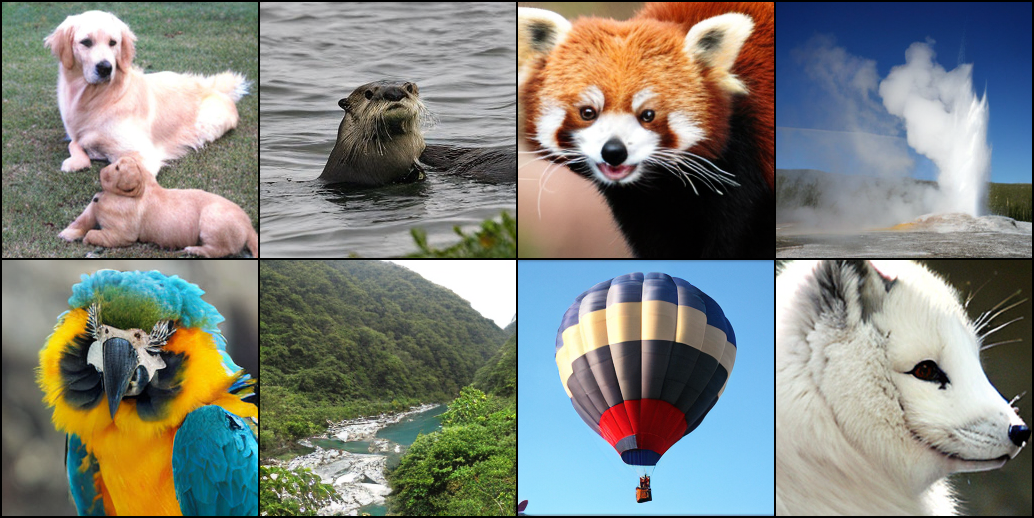

In [3]:
#ユーザー入力を設定します。
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 250 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 4 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = 207, 360, 387, 974, 88, 979, 417, 279 #@param {type:"raw"}
samples_per_row = 4 #@param {type:"number"}

#ディフュージョンオブジェクトを作成します。
diffusion = create_diffusion(str(num_sampling_steps))

#サンプリングノイズを発生させる。
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# クラシファイアフリーガイドを設定する。
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# サンプル画像です。
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False, 
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# 画像の保存と表示
save_image(samples, "sample.png", nrow=int(samples_per_row), 
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)